In [1]:
from itertools import chain

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import scipy
import networkx as nx
import umap
import nglpy

from scipy.sparse.csgraph import laplacian

from sklearn.cluster import SpectralClustering
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import rbf_kernel, cosine_similarity
from sklearn.cluster import SpectralClustering
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix, make_scorer, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics.pairwise import rbf_kernel, cosine_similarity, kernel_metrics
from sklearn.metrics import pairwise_distances

from sklearn.model_selection import train_test_split

import feature, utils

## Simple graph

/home/omar/.cache/pypoetry/virtualenvs/snow-leopard-O1gqMmLm-py3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


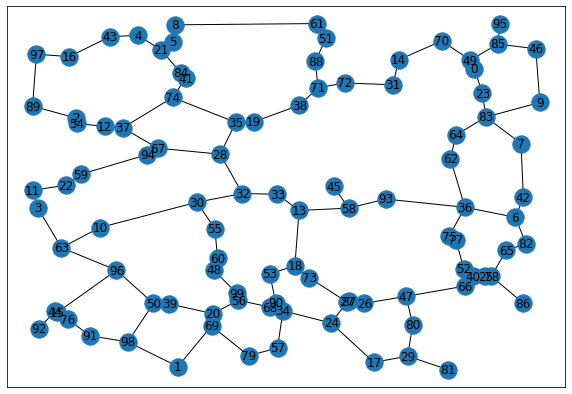

In [2]:
point_set = np.random.rand(100, 2)

# Construct a relative neighborhood graph
aGraph = nglpy.EmptyRegionGraph(max_neighbors=10, relaxed=False, beta=2, p=2.0)
aGraph.build(point_set)
neigbours = aGraph.neighbors()
#print(neigbours)

G = nx.Graph()
for node, neibouring_nodes in neigbours.items():
    for child in neibouring_nodes:
        G.add_edge(node, child)
        
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x=point_set[:,0],y=point_set[:,1], ax=ax)

fixed_positions = {i: tuple(point_set[i]) for i in range(point_set.shape[0])}
fixed_nodes = fixed_positions.keys()
pos = nx.spring_layout(G,pos=fixed_positions, fixed = fixed_nodes)
nx.draw_networkx(G,pos, ax=ax)



In [3]:
D = pairwise_distances(point_set, metric="euclidean")

a = 93
b = 16
c = 31

D[a,b] <= max(D[a,c], D[b,c])
print(f"{D[a,b]} <= {max(D[a,c], D[b,c])}: {D[a,b] <= max(D[a,c], D[b,c])}")

0.7305503194938326 <= 0.6247328532126298: False


## Real-world data set

In [4]:
# Load data
df_data = pd.read_csv('../data/ice-cat-office-products.csv.gz', dtype=str, index_col=0)

category_counts = df_data["category_name"].value_counts()
large_enough_categories = category_counts[category_counts > 20].index.tolist()

df_data = df_data[df_data.category_name.isin(large_enough_categories)]

# Filter out small product categories
# top_categories = utils.find_top_n_categories(df_data, top_n=3)
top_categories = [
#     'Folders',                     # N=645
#     'Self-Adhesive Labels',        # N=324
#     'Multimedia Carts & Stands',   # N=317
#     'Calculators',                 # N=305
#     'Writing Notebooks'            # N=300
#     'Ring Binders',                # N=298
#     'Printer Cabinets & Stands',   # N=252
#     'Whiteboards',                 # N=232
#     'Fax Machines',                # N=210
#     'File Storage Boxes'           # N=192
#     'Binding Covers',              # N=190
#     'Self-Adhesive Note Paper',    # N=172
#     'Staplers',                    # N=162
#     'Desk Trays/Organizers',       # N=159
#     'Board Accessories',           # N=154
#     'Seals',                       # N=145
#     'Computer Desks',              # N=144
#     'Hole Punches',                # N=136
#     'Hanging Folders',             # N=132
#     'Interactive Whiteboards',     # N=131
#     'Laminator Pouches',           # N=128
#     'Stationery Tapes',            # N=124
#     'Bulletin Boards',             # N=123
#     'Tab Indexes',                 # N=114
    'Folder Binding Accessories',  # N=109
    'Non-Adhesive Labels',         # N=103
]
df_data = df_data[df_data.category_name.isin(top_categories)]
print(f"Number of categories: {len(df_data.category_name.unique())}")

Number of categories: 2


In [5]:
feateure_transformer = feature.BasicIceCatFeatureTransformer(output_size=0.99)

In [6]:
df_data.sort_values(by="category_name", inplace=True)

In [7]:
X = feateure_transformer.fit_transform(df_data)

In [8]:
aGraph = nglpy.EmptyRegionGraph(max_neighbors=10, relaxed=False, beta=2, p=2.0)
aGraph.build(X)
neigbours = aGraph.neighbors()

G = nx.Graph()

for node, neibouring_nodes in neigbours.items():
    for child in neibouring_nodes:
        G.add_edge(node, child)

/home/omar/.cache/pypoetry/virtualenvs/snow-leopard-O1gqMmLm-py3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [9]:
df_data["category_name"] = df_data["category_name"].astype('category')

In [10]:
X_2d = umap.UMAP().fit_transform(X)

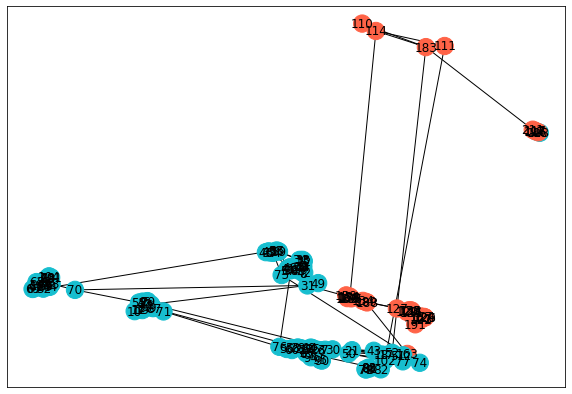

In [11]:
fig, ax = plt.subplots(figsize=(10, 7))
# sns.scatterplot(x=point_set[:,0],y=point_set[:,1], ax=ax)

available_colors = ["tab:cyan", "tomato", "yellow", "orange", "skyblue", "lime"]
cat_codes = list(df_data["category_name"].cat.codes)
color_map = [available_colors[cat_codes[node]] for node in G]
fixed_positions = {i: tuple(X_2d[i]) for i in G.nodes}
fixed_nodes = fixed_positions.keys()
pos = nx.spring_layout(G,pos=fixed_positions, fixed = fixed_nodes)
nx.draw_networkx(G, pos, node_color=color_map, ax=ax)
# nx.draw_networkx(G, node_color=color_map, ax=ax)

<AxesSubplot:>

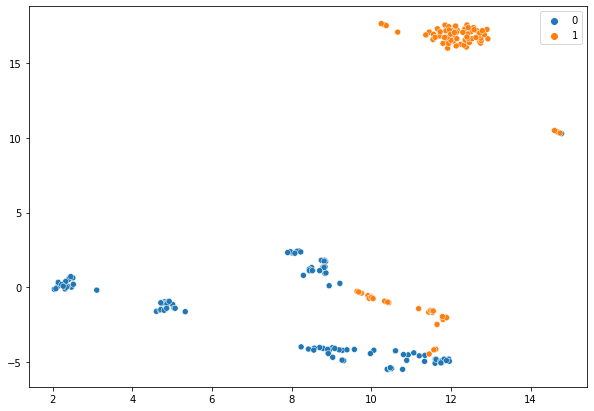

In [12]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1],hue=list(df_data["category_name"].cat.codes), ax=ax)